# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

## Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") 

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

import os
import math

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline


## API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

In [6]:
for col in data:
    data[col]=pd.to_numeric(data[col], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

## Define performance measurement

We will evaluate the model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of the submission will be partially based on how you made (and described) the trade-off.

We may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

## Train test split

In [7]:
X = data.drop(columns=['Bankrupt', 'Id'])
y = data['Bankrupt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Exploratory Data Analysis

## Check the distribution of target value

This is a highly imbalanced dataset. Companies that didn't go bankrupcy is 15 times higher than those went bankrupcy.

We will handle the imbalanced data later.

Class 0: 3609
Class 1: 245
Proportion: 14.73 : 1


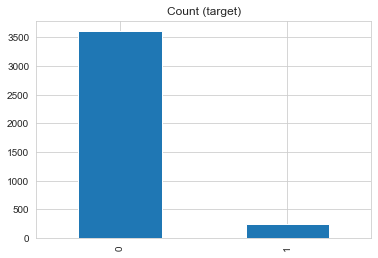

In [8]:
target_count = y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

## Correlation matrix

At first sight, there are many squares showing significant the correlation is amog the variables. For example, [X1, X3, X7, X10, X11] are highly correlated. Actually, this correlation is so strong that it can indicate a situation of multicollinearity.

Another thing was the **Bankrupt** correlations. We can see few variables have strong correlation with target value.

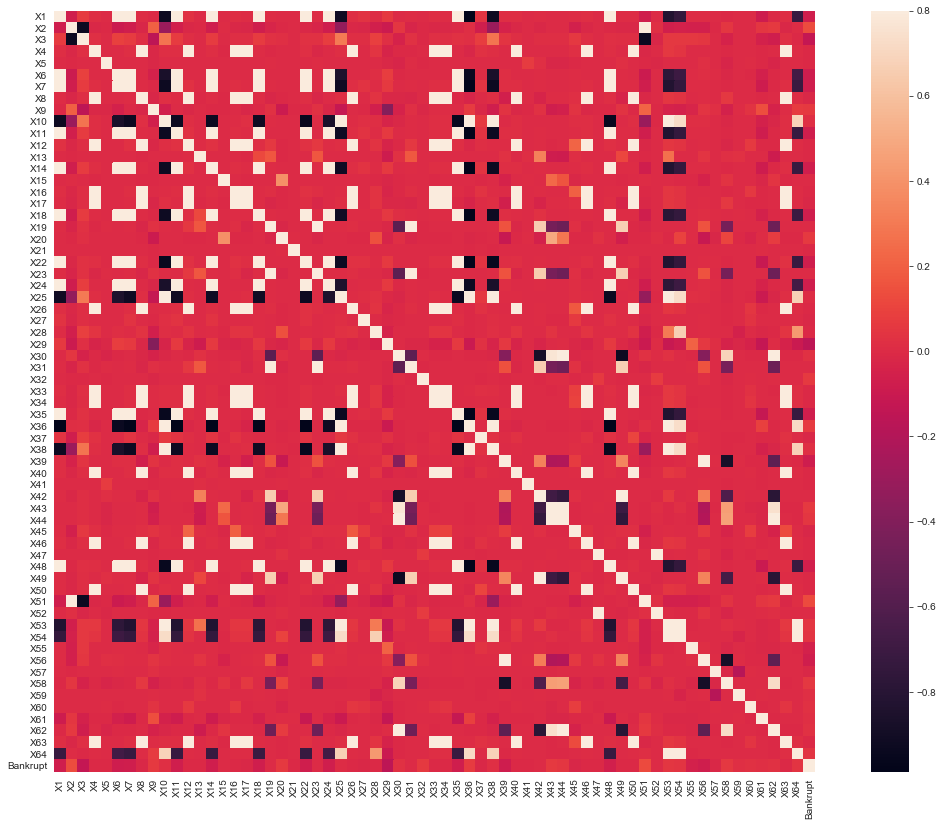

In [9]:
df = X_train.copy()
df['Bankrupt'] = y_train
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(corrmat, vmax=.8, square=True);


# Prepare the data

## Cleaning: handle missing data

### Remove columns that has large percentage of NaNs

We find that some features were sparse and might not be helpful in the model. In this way, we will remove those features.

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Sparsity of data')

Text(0.5, 0, '# Column')

Text(0, 0.5, 'Percent of NaNs for Given Column')

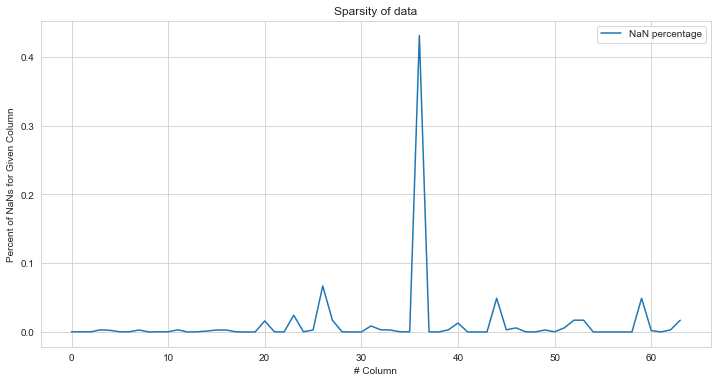

In [10]:
# check sparsity of column data
def check_sparsity_columns(df):
    sparsity = df.isna().mean() 
    return sparsity

column_sparsity = check_sparsity_columns(X_train)

plt.figure(figsize=(12,6))
plt.title('Sparsity of data')
plt.plot(column_sparsity.values, label='NaN percentage')
plt.legend()
plt.xlabel('# Column')
plt.ylabel('Percent of NaNs for Given Column')

In [11]:
# remove sparse columns
remove_threshold = 0.2
remove_columns = column_sparsity[column_sparsity>remove_threshold].index
print('Remove columns due to sparsity: {}'.format(remove_columns))

X_train = X_train.drop(columns=remove_columns)
X_test = X_test.drop(columns=remove_columns)

Remove columns due to sparsity: Index(['X37'], dtype='object')


### Remove rows that has large percentage of NaNs

For some data points, large portion of features are NaNs. We will ignore those data points.

In [12]:
# check sparsity of row data and remove sparse rows
def check_sparsity_rows(df, remove_threshold=0.3):
    remove_row = list(df[df.isnull().mean(axis=1) > remove_threshold].index)
    keep_row = list(df[df.isnull().mean(axis=1) <= remove_threshold].index)

    print('Percent of Removed Rows: {}'.format(len(remove_row)/df.shape[0]))    
    
    return keep_row
keep_row = check_sparsity_rows(X_train, remove_threshold=0.3)
X_train = X_train.loc[keep_row, :]
y_train = y_train.loc[keep_row]
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

Percent of Removed Rows: 0.0007784120394395433
X_train shape:  (3851, 63)
y_train shape:  (3851,)


### Imputation of missing values

We will first use univariate imputation algorithms, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension.

Since the features are financial indicator and the mean is meaningful, we use univariate imputator to fill missing values.

In [13]:
univariate_columns = X_train.columns
   
imputer_uni = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[univariate_columns] = imputer_uni.fit_transform(X_train[univariate_columns])
X_test[univariate_columns] = imputer_uni.transform(X_test[univariate_columns])

Here we will use multivariate imputation algorithms to estimate other the missing values.

In [14]:
imputer_multi = KNNImputer(n_neighbors=5, weights="uniform")

X_train[X_train.columns] = imputer_multi.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = imputer_multi.transform(X_test[X_test.columns])
X_test.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
1011,0.038369,0.75192,0.158290,1.25610,-145.050,-0.010509,0.049303,0.33019,1.18750,0.24827,...,227.14,0.055751,0.154550,0.94495,0.541250,1.9972,17.0840,189.970,1.9214,5.3059
2063,0.030155,0.66965,0.340290,2.45130,82.879,0.130020,0.039204,0.48170,1.07940,0.32257,...,49597.00,0.073596,0.093483,0.92640,1.349100,12.9210,5.4860,84.343,4.3276,2.3863
2898,-0.008349,0.65765,-0.073715,0.83291,-172.640,-0.033460,-0.015940,0.30968,1.03370,0.20366,...,-13598.00,0.032582,-0.040994,0.96742,1.062900,3.2773,6.6665,231.370,1.5776,1.1003
113,0.138460,0.07828,0.508770,8.55170,206.180,0.000000,0.138460,11.77500,0.86611,0.92172,...,2369.20,0.143550,0.150220,0.84392,0.011835,7.6556,4.1827,28.392,12.8560,2.0434
1098,-0.002828,0.22518,0.760790,4.43780,52.846,0.000000,0.003116,3.44090,2.30470,0.77482,...,2148.00,0.002692,-0.003649,0.99866,0.000000,5.4463,10.0060,35.048,10.4140,128.7200


## Handle imbalanced data

We consider several ways to handle imbalanced data problem:
    
**1. Under-sampling:** Since the data amount we have is small, if we under-sampling the dataset, the useful data are drop too much.

**2. Over-sampling:** This might be a usefull way to handle the problem. But the data amount with bankrupt=1 is so small that it is less helpful. We will use this method here.

**3. Loss sensitive training:** We can adjust the loss function to weight conditional probabilities easily. **Therefore we will use this method later in our models.**

Random over-sampling:
1    3607
0    3607
Name: Bankrupt, dtype: int64


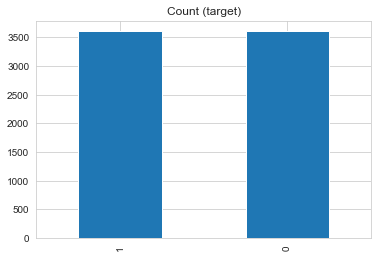

In [15]:
# Over-sampling class count
def over_sampling(X_train, y_train):
    count_class_0, count_class_1 = y_train.value_counts()

    X_class_0 = X_train[y_train == 0]
    X_class_1 = X_train[y_train == 1]
    y_class_0 = y_train[y_train == 0]
    y_class_1 = y_train[y_train == 1]

    X_class_1_over = X_class_1.sample(count_class_0, replace=True)
    y_class_1_over = y_class_1.sample(count_class_0, replace=True)

    X_train_over = pd.concat([X_class_0, X_class_1_over], axis=0)
    y_train_over = pd.concat([y_class_0, y_class_1_over], axis=0)
    return X_train_over, y_train_over

X_train_over, y_train_over = over_sampling(X_train, y_train)

print('Random over-sampling:')
print(y_train_over.value_counts())

y_train_over.value_counts().plot(kind='bar', title='Count (target)')

## Transformation and feature engineering

### Scaling

From EDA we find that many of the features have extreme values, therefore we have to use scale the features.

In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()

### PCA to reduce feature dimension

As we have discovered before, many features are highly correlated and bring multicollinearity problem. We can reduce the demension of the features using PCA.

5 has a cumulative explained variane of: 0.998190554885772


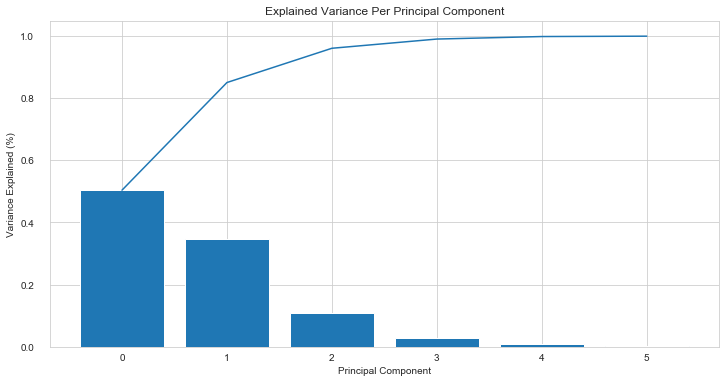

In [17]:
from sklearn.decomposition import PCA

def scree_plot(pca_estimator):

    num_components = len(pca_estimator.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_estimator.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca = PCA(n_components = .999)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scree_plot(pca)

n_components = 5
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 2 components. 

Then we will have a look at the components for each principle component.

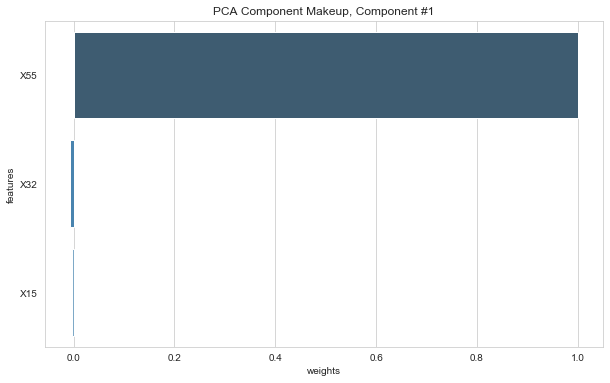

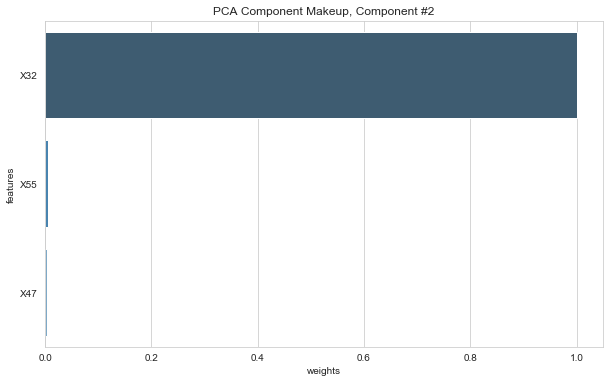

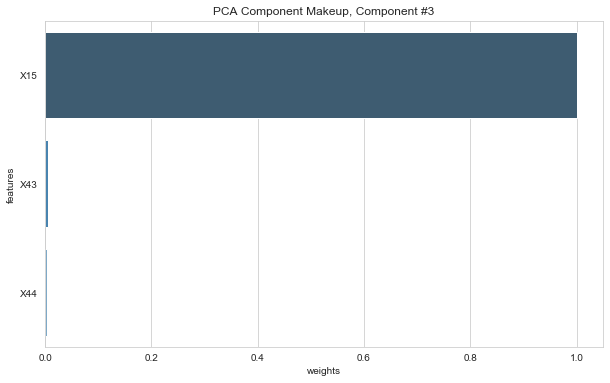

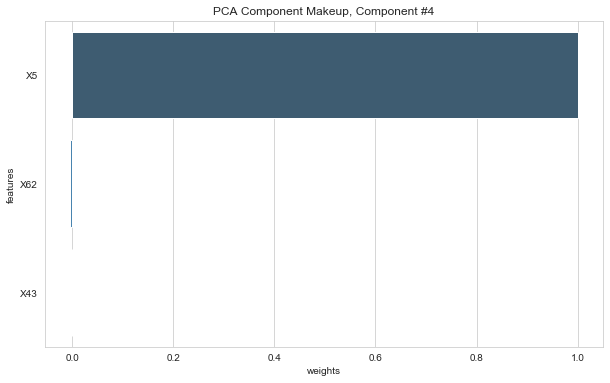

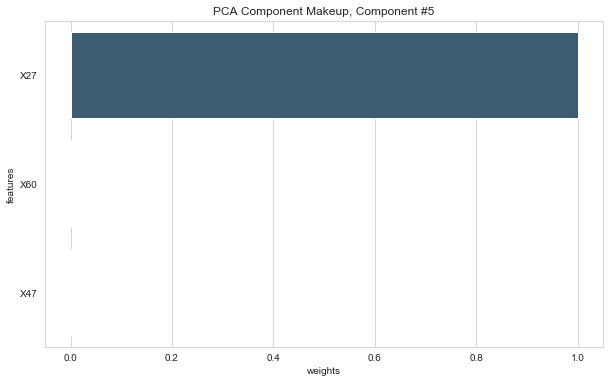

In [18]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num - 1

    # get the list of weights from a row in v, dataframe
    v_1_row = v[row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

for num in range (1,6):
    display_component(pca.components_, X_train.columns.values, component_num=num, n_weights=3)

**Conclusion**

We find that [X5, X27, X15, X32, X55] can explain most of the variance of the target. And we can use three principle components in our model later.

# Model training

We will test the model with the measument **accuracy, precision, recall**.

To measure the trade-off between precision and recall, we will also use **F-beta score** with beta=2 because it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt. F-beta score help use to put more weights on recall. 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

cross_validation_k = 5

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3851, 63)
X_test shape:  (964, 63)
y_train shape:  (3851,)
y_test shape:  (964,)


All the models are tested using the same process.

In [20]:
@ignore_warnings(category=ConvergenceWarning)
def test_model(X_train, X_test, y_train, y_test, test_pipelilne, name, cv=False, show_confusion=False, roc_curve=False):
    
    test_pipelilne.fit(X_train, y_train)
    y_train_predict = test_pipelilne.predict(X_train)

    accuracy_is = accuracy_score(y_train, y_train_predict)
    precision_is = precision_score(y_train, y_train_predict, pos_label=1, average="binary")
    recall_is = recall_score(y_train, y_train_predict, pos_label=1, average="binary")
    fbeta_is = fbeta_score(y_train, y_train_predict, beta=2, pos_label=1, average="binary")

    print("Model: {m:s} in-sample Accuracy: {a:3.1%}, Recall: {r:3.1%}, Precision: {p:3.1%},\
          F-beta {f:3.1%}".format(m=name, a=accuracy_is, r=recall_is, p=precision_is, f=fbeta_is))

    if cv:
        cross_val_scores = cross_val_score(test_pipelilne, X_train, y_train, cv=cross_validation_k)
        print("Model: {m:s} avg cross validation accuracy={s:3.2f}".format(m=name, s=cross_val_scores.mean()))

    y_test_predict = test_pipelilne.predict(X_test)

    accuracy_oos = accuracy_score(y_test, y_test_predict)
    precision_oos = precision_score(y_test, y_test_predict, pos_label=1, average="binary")
    recall_oos = recall_score(y_test, y_test_predict, pos_label=1, average="binary")
    fbeta_oos = fbeta_score(y_test, y_test_predict, beta=2, pos_label=1, average="binary")
    
    print("Model: {m:s} out-of-sample Accuracy: {a:3.1%}, Recall: {r:3.1%}, Precision: {p:3.1%},\
          F-beta: {f:3.1%}".format(m=name, a=accuracy_oos, r=recall_oos, p=precision_oos, f=fbeta_oos))
    
    if show_confusion:
        mat = confusion_matrix(y_test, y_test_predict)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d',cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
    if roc_curve:
        plot_roc_curve_(test_pipelilne, X=X_test, y=y_test)
    
    return test_pipelilne

def plot_roc_curve_(clf, X, y):  
    probs = clf.predict_proba(X)  
    probs = probs[:, 1]

    fpr, tpr, thresholds = roc_curve(y, probs)
    auc_a = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % auc_a )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Benchmark model: logistics regression

With logistic model, we will apply the following variations:
1. Logisitc regression with original class weight from train data.
2. Logistic regression with balanced class weight.
3. Logistic regression with balanced class weight and regularization.
4. Logistic model with balanced class weight and PCA components.
5. Logistic model with balanced datasets.

 1. logistic model with unbalanced class weight:
Model: Logistic in-sample Accuracy: 93.6%, Recall: 5.7%, Precision: 48.3%,          F-beta 7.0%
Model: Logistic out-of-sample Accuracy: 93.4%, Recall: 11.1%, Precision: 46.7%,          F-beta: 13.1%


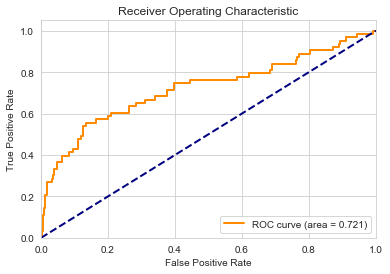


 2. logistic model with balanced class weight:
Model: Logistic in-sample Accuracy: 82.4%, Recall: 77.5%, Precision: 23.2%,          F-beta 52.8%
Model: Logistic out-of-sample Accuracy: 79.3%, Recall: 58.7%, Precision: 17.5%,          F-beta: 40.0%

 3. logistic model with balanced class weight and regularizaiton:
Model: Logistic in-sample Accuracy: 79.2%, Recall: 70.9%, Precision: 19.2%,          F-beta 46.0%
Model: Logistic out-of-sample Accuracy: 76.0%, Recall: 69.8%, Precision: 17.2%,          F-beta: 43.3%

 4. logistic model with balanced class weight and PCA components:
Model: Logistic in-sample Accuracy: 54.8%, Recall: 84.4%, Precision: 10.8%,          F-beta 35.7%
Model: Logistic out-of-sample Accuracy: 54.4%, Recall: 81.0%, Precision: 10.6%,          F-beta: 34.9%

 5. logistic model with balanced datasets:
Model: Logistic in-sample Accuracy: 79.6%, Recall: 78.2%, Precision: 80.4%,          F-beta 78.7%
Model: Logistic out-of-sample Accuracy: 77.9%, Recall: 65.1%, Precision: 

In [21]:
print(' 1. logistic model with unbalanced class weight:')
name = 'Logistic'
clf_logistic = LogisticRegression(solver='liblinear',max_iter=100)
pipeline_logistic = Pipeline([
    ("scaler", scaler), 
    ("model", clf_logistic)
])
pipeline_logistic = test_model(X_train, X_test, y_train, y_test, pipeline_logistic, name, cv=False, show_confusion=False, roc_curve=True)

print('\n 2. logistic model with balanced class weight:')
clf_logistic = LogisticRegression(solver='liblinear',max_iter=100,class_weight='balanced')
pipeline_logistic = Pipeline([
    ("scaler", scaler), 
    ("model", clf_logistic)
])
pipeline_logistic = test_model(X_train, X_test, y_train, y_test, pipeline_logistic, name)


print('\n 3. logistic model with balanced class weight and regularizaiton:')
clf_logistic = LogisticRegression(solver='liblinear',max_iter=100,class_weight='balanced',C=0.01)
pipeline_logistic = Pipeline([
    ("scaler", scaler), 
    ("model", clf_logistic)
])
pipeline_logistic = test_model(X_train, X_test, y_train, y_test, pipeline_logistic, name)

print('\n 4. logistic model with balanced class weight and PCA components:')
clf_logistic = LogisticRegression(solver='liblinear',max_iter=100,class_weight='balanced')
pipeline_logistic = Pipeline([
    ("scaler", scaler), 
    ("model", clf_logistic)
])
pipeline_logistic = test_model(X_train_pca, X_test_pca, y_train, y_test, pipeline_logistic, name)

print('\n 5. logistic model with balanced datasets:')
clf_logistic = LogisticRegression(solver='liblinear',max_iter=100)
pipeline_logistic = Pipeline([
    ("scaler", scaler), 
    ("model", clf_logistic)
])
pipeline_logistic = test_model(X_train_over, X_test, y_train_over, y_test, pipeline_logistic, name)

**Conclusion**

1. logistic regression with unbalanced class weight has good accuracy but low F-beta score.
2. Adding balanced class weight to handle imbalanced data problem increases the F-beta score, but the accuracy drops greatly.
3. Using PCA components does not improve the performance in any way.
4. Using balanced datasets shows best performance.

## Benchmark Model: naive bayes

In [22]:
name = 'Naive Bayes'
clf_nb = GaussianNB()
pipeline_nb = Pipeline([
    ("scaler", scaler), 
    ("model", clf_nb)
])

pipeline_nb = test_model(X_train, X_test, y_train, y_test, pipeline_nb, name)

Model: Naive Bayes in-sample Accuracy: 92.1%, Recall: 17.6%, Precision: 29.1%,          F-beta 19.1%
Model: Naive Bayes out-of-sample Accuracy: 92.2%, Recall: 22.2%, Precision: 35.0%,          F-beta: 24.0%


**Conclusion**

Naive bayes has strong performance in F-beta score, but has poor accuracy. We will not use this model later.

## Decison Tree


 1. decision tree with imbalanced class weight:
Model: decision_tree in-sample Accuracy: 100.0%, Recall: 100.0%, Precision: 100.0%,          F-beta 100.0%
Model: decision_tree out-of-sample Accuracy: 94.0%, Recall: 46.0%, Precision: 54.7%,          F-beta: 47.5%


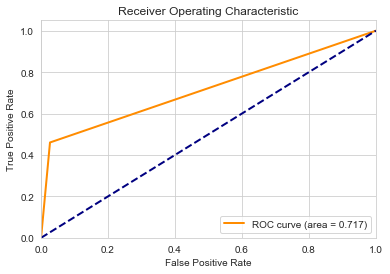


 2. decision tree with balanced class weight:
Model: decision_tree in-sample Accuracy: 100.0%, Recall: 100.0%, Precision: 100.0%,          F-beta 100.0%
Model: decision_tree out-of-sample Accuracy: 93.2%, Recall: 47.6%, Precision: 47.6%,          F-beta: 47.6%

 3. decision tree with balanced class weight and PCA components:
Model: decision_tree in-sample Accuracy: 100.0%, Recall: 100.0%, Precision: 100.0%,          F-beta 100.0%
Model: decision_tree out-of-sample Accuracy: 91.0%, Recall: 22.2%, Precision: 26.9%,          F-beta: 23.0%

 4. decision tree with balanced datasets:
Model: decision_tree in-sample Accuracy: 100.0%, Recall: 100.0%, Precision: 100.0%,          F-beta 100.0%
Model: decision_tree out-of-sample Accuracy: 92.9%, Recall: 34.9%, Precision: 44.9%,          F-beta: 36.5%


In [23]:
print('\n 1. decision tree with imbalanced class weight:')
name = 'decision_tree'
clf_dt = DecisionTreeClassifier(random_state=0)
pipeline_dt = Pipeline([
    ("scaler", scaler), 
    ("model", clf_dt)
])
pipeline_dt = test_model(X_train, X_test, y_train, y_test, pipeline_dt, name,cv=False, show_confusion=False, roc_curve=True)

print('\n 2. decision tree with balanced class weight:')
name = 'decision_tree'
clf_dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')
pipeline_dt = Pipeline([
    ("scaler", scaler), 
    ("model", clf_dt)
])
pipeline_dt = test_model(X_train, X_test, y_train, y_test, pipeline_dt, name)

print('\n 3. decision tree with balanced class weight and PCA components:')
name = 'decision_tree'
clf_dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')
pipeline_dt = Pipeline([
    ("scaler", scaler), 
    ("model", clf_dt)
])
pipeline_dt = test_model(X_train_pca, X_test_pca, y_train, y_test, pipeline_dt, name)

print('\n 4. decision tree with balanced datasets:')
name = 'decision_tree'
clf_dt = DecisionTreeClassifier(random_state=0)
pipeline_dt = Pipeline([
    ("scaler", scaler), 
    ("model", clf_dt)
])
pipeline_dt = test_model(X_train_over, X_test, y_train_over, y_test, pipeline_dt, name)


## More models and ensembling

In [24]:
names = [
    'Logistic',    
    "NearestNeighbors",
    "SVC",
    "DecisionTree",
    "RandomForest",
    "NeuralNet",
    "AdaBoost",
    "GradientBoosting"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(gamma="scale", class_weight="balanced"),    
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(max_depth=5,class_weight='balanced'),
    MLPClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100)]

clf_pipeline_lst = []
for name, clf in zip(names, classifiers):
    print('-------------------------------------')
    print('Classifier: {}'.format(name))
    clf_pipeline = Pipeline([ 
        ("scaler", scaler), 
        ("model", clf)
    ])
    print('1. With original features:')
    clf_pipeline = test_model(X_train, X_test, y_train, y_test, clf_pipeline, name)
    print('2. With PCA features:')    
    clf_pipeline = test_model(X_train_pca, X_test_pca, y_train, y_test, clf_pipeline, name)
    print('3. With balanced data features:')
    clf_pipeline = test_model(X_train_over, X_test, y_train_over, y_test, clf_pipeline, name)

    print('-------------------------------------')
    clf_pipeline_lst.append(clf_pipeline)

-------------------------------------
Classifier: Logistic
1. With original features:
Model: Logistic in-sample Accuracy: 93.6%, Recall: 5.7%, Precision: 48.3%,          F-beta 7.0%
Model: Logistic out-of-sample Accuracy: 93.4%, Recall: 11.1%, Precision: 46.7%,          F-beta: 13.1%
2. With PCA features:
Model: Logistic in-sample Accuracy: 93.5%, Recall: 0.4%, Precision: 14.3%,          F-beta 0.5%
Model: Logistic out-of-sample Accuracy: 93.5%, Recall: 3.2%, Precision: 50.0%,          F-beta: 3.9%
3. With balanced data features:
Model: Logistic in-sample Accuracy: 79.6%, Recall: 78.2%, Precision: 80.4%,          F-beta 78.7%
Model: Logistic out-of-sample Accuracy: 77.9%, Recall: 65.1%, Precision: 17.7%,          F-beta: 42.4%
-------------------------------------
-------------------------------------
Classifier: NearestNeighbors
1. With original features:
Model: NearestNeighbors in-sample Accuracy: 94.6%, Recall: 20.9%, Precision: 77.3%,          F-beta 24.5%
Model: NearestNeighbors o

We can see that 

1. DecisionTree, RandomForest, AdaBoost models both provides high accuracy and F-beta score. We will combine those models using voting classifier.
2. Using original features instead of PCA features always make better performance.
3. Using balanced datasets shows great performance.

In [25]:
clf1 = DecisionTreeClassifier(max_depth=7,class_weight='balanced')
clf2 = RandomForestClassifier(max_depth=5,class_weight='balanced')
clf3 = AdaBoostClassifier()
clf4 = MLPClassifier(alpha=1, max_iter=1000)
clf5 = GradientBoostingClassifier(n_estimators=100)

name = 'VotingClassifier'
eclf = VotingClassifier(estimators=
                        [
                         ('clf1', clf1),
                         ('clf2', clf2),
                         ('clf3', clf3), 
                         ('clf4', clf4),
                         ('clf5', clf5)],                        
                        weights=[1,1,1,2,5],
                        voting='hard') 

voting_pipeline = Pipeline([ 
        ("scaler", scaler), 
        ("model", eclf)
    ])
voting_pipeline = test_model(X_train_over, X_test, y_train_over, y_test, voting_pipeline, name)


Model: VotingClassifier in-sample Accuracy: 97.5%, Recall: 98.3%, Precision: 96.8%,          F-beta 98.0%
Model: VotingClassifier out-of-sample Accuracy: 93.6%, Recall: 71.4%, Precision: 50.6%,          F-beta: 66.0%


## Error analysis

Since the features dimensions are high, it is hard to find a pattern for a wrong classification. We will use some ways to visualize the wrong cases.

In [26]:
y_test_pred = voting_pipeline.predict(X_test)

error_index = y_test_pred != y_test
showdata = X_test.copy()
showdata['y_real'] = y_test
showdata['y_pred'] = y_test_pred
showdata.loc[error_index].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,y_real,y_pred
1011,0.038369,0.75192,0.15829,1.25610,-145.050,-0.010509,0.049303,0.330190,1.1875,0.248270,...,0.15455,0.94495,0.54125,1.9972,17.0840,189.970,1.9214,5.3059,1,0
1692,0.026393,0.87172,-0.20206,0.67986,-209.050,0.000000,0.026393,0.147160,1.1413,0.128280,...,0.20574,0.70836,1.87460,8.1829,3.9957,201.860,1.8082,1.9991,0,1
1022,-0.158900,0.72937,-0.34444,0.52775,-73.942,-0.219630,-0.158900,0.371050,1.1777,0.270630,...,-0.58714,1.09960,0.00000,3932.0000,3.0744,226.060,1.6146,1.9147,0,1
2457,0.238070,0.91537,-0.31899,0.61890,-78.523,-0.193480,0.309340,0.092461,2.7125,0.084636,...,2.81280,0.88644,0.00000,17.8280,10.0960,112.630,3.2406,5.6282,0,1
3986,-0.201150,0.13881,0.51086,4.91510,84.763,-0.359030,-0.201150,6.204300,1.8003,0.861200,...,-0.23357,1.10430,0.00000,96.6950,4.1097,26.455,13.7970,5.0194,0,1


# Fine tuning

## Grid search

We will grid search the parameters based on f-beta scores. However other parameters does not improve the performance.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=2)

params = {
    'clf2__max_depth': [3,5,7],
    'clf3__n_estimators': [25,50,100]
         }
grid_clf_pipeline = Pipeline([ 
        ("scaler", scaler), 
        ("model", GridSearchCV(estimator=eclf, param_grid=params, cv=5, scoring=ftwo_scorer))
    ])
grid_clf_pipeline = test_model(X_train_over, X_test, y_train_over, y_test, grid_clf_pipeline, name)


Model: VotingClassifier in-sample Accuracy: 97.7%, Recall: 98.7%, Precision: 96.8%,          F-beta 98.3%
Model: VotingClassifier out-of-sample Accuracy: 93.6%, Recall: 71.4%, Precision: 50.6%,          F-beta: 66.0%


In [28]:
grid_clf_pipeline['model'].best_params_

{'clf2__max_depth': 7, 'clf3__n_estimators': 100}

## Final model

In [29]:
# remove NaNs
X_all = X.drop(columns=remove_columns) 

final_imputer_uni = SimpleImputer(missing_values=np.nan, strategy='mean')
X_all[univariate_columns] = final_imputer_uni.fit_transform(X_all[univariate_columns])

final_imputer_multi = KNNImputer(n_neighbors=5, weights="uniform")
X_all[X_all.columns] = final_imputer_multi.fit_transform(X_all[X_all.columns])

X_all_over, y_over = over_sampling(X_all, y)


## model
clf1 = DecisionTreeClassifier(max_depth=7,class_weight='balanced')
clf2 = RandomForestClassifier(max_depth=7,class_weight='balanced')
clf3 = AdaBoostClassifier(n_estimators=100)
clf4 = MLPClassifier(alpha=1, max_iter=1000)
clf5 = GradientBoostingClassifier(n_estimators=100)

eclf = VotingClassifier(estimators=
                        [
                         ('clf1', clf1),
                         ('clf2', clf2),
                         ('clf3', clf3), 
                         ('clf4', clf4),
                         ('clf5', clf5)],                        
                        weights=[1,1,1,2,5],
                        voting='hard') 

final_pipeline = Pipeline([ 
        ("scaler", scaler), 
        ("model", eclf)
    ])

final_pipeline.fit(X_all_over, y_over)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 VotingClassifier(estimators=[('clf1',
                                               DecisionTreeClassifier(ccp_alpha=0.0,
                                                                      class_weight='balanced',
                                                                      criterion='gini',
                                                                      max_depth=7,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                                                      m

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [30]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )
print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [31]:
import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    if 'Id' in X:
        X = X.drop(columns=['Id'])
    for col in X:
        X[col]=pd.to_numeric(X[col], errors='coerce')

    # drop sparse feature    
    X = X.drop(columns=remove_columns)
    
    X[univariate_columns] = final_imputer_uni.transform(X[univariate_columns])
    X[X.columns] = final_imputer_multi.transform(X[X.columns])
        
    predictions = final_pipeline.predict(X)
    
    return predictions
name = 'VotingClassifer'
y_hold_pred = MyModel(holdout_data)

# Compute metrics
accuracy_hold = accuracy_score(y_hold, y_hold_pred)
recall_hold = recall_score(y_hold, y_hold_pred, pos_label=1, average="binary")
precision_hold = precision_score(y_hold, y_hold_pred, pos_label=1, average="binary")


print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name, a=accuracy_hold, r=recall_hold, p=precision_hold))

NameError: name 'y_hold' is not defined

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [32]:
from sklearn.utils import shuffle

name = "Voting Classifer"
y_check, X_check = shuffle(y, X, random_state=42)
X_check_test = X_check.iloc[:1000,:]
y_check_test = y_check.iloc[:1000]

y_check_pred = MyModel(X_check_test)

accuracy_test = accuracy_score(y_check_test, y_check_pred)
recall_test = recall_score(y_check_test, y_check_pred, pos_label=1, average="binary")
precision_test = precision_score(y_check_test, y_check_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	Voting Classifer Accuracy: 97.0%, Recall 94.4%, Precision 72.0%


D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
